# LAB | Audio Classification CNN

## Introduction
This notebook guides you through audio classification using a CNN model on the Kaggle audio dataset. You will:
- Load and explore the dataset
- Apply various preprocessing methods (MFCC, Mel spectrogram, Chromagram)
- Build and train a CNN classifier on these features
- Experiment with preprocessing parameters to improve results

## Step 1: Setup & Dataset Loading

In [1]:
# !pip install librosa

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("warcoder/cats-vs-dogs-vs-birds-audio-classification")

print("Path to dataset files:", path)

100%|██████████| 13.2M/13.2M [00:00<00:00, 69.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification/versions/1


In [4]:
files_in_dir = os.listdir(path)
print(files_in_dir)

['Animals']


In [5]:
#TODO: create a dataframe
df = pd.DataFrame()

## Step 2: Audio Preprocessing Functions

Define functions for feature extraction you will experiment with:

- MFCC
- Spectrogram
- Chromogram

In [6]:
# Create a dataframe with file paths and labels
audio_files = []
labels = []

# Navigate through the Animals directory
animals_path = os.path.join(path, 'Animals')
for category in os.listdir(animals_path):
    category_path = os.path.join(animals_path, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            if file.endswith('.wav'):
                audio_files.append(os.path.join(category_path, file))
                labels.append(category)

df = pd.DataFrame({'file_path': audio_files, 'label': labels})
print(f"Total audio files: {len(df)}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")
print(f"\nFirst few rows:\n{df.head()}")



def extract_mfcc(file_path, n_mfcc=40, max_len=100):
    """Extract MFCC features from audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate to max_len
        if mfcc.shape[1] < max_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_mel_spectrogram(file_path, n_mels=128, max_len=100):
    """Extract Mel Spectrogram features from audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Pad or truncate to max_len
        if mel_spec_db.shape[1] < max_len:
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, max_len - mel_spec_db.shape[1])), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_len]
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_chromagram(file_path, n_chroma=12, max_len=100):
    """Extract Chromagram features from audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=n_chroma)
        # Pad or truncate to max_len
        if chroma.shape[1] < max_len:
            chroma = np.pad(chroma, ((0, 0), (0, max_len - chroma.shape[1])), mode='constant')
        else:
            chroma = chroma[:, :max_len]
        return chroma
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("Feature extraction functions defined successfully!")

Total audio files: 610

Class distribution:
label
dog     210
cat     207
bird    193
Name: count, dtype: int64

First few rows:
                                           file_path label
0  /root/.cache/kagglehub/datasets/warcoder/cats-...  bird
1  /root/.cache/kagglehub/datasets/warcoder/cats-...  bird
2  /root/.cache/kagglehub/datasets/warcoder/cats-...  bird
3  /root/.cache/kagglehub/datasets/warcoder/cats-...  bird
4  /root/.cache/kagglehub/datasets/warcoder/cats-...  bird
Feature extraction functions defined successfully!


## Step 3: Visualize Audio Features

Visualize extracted features for a sample audio file:

Visualizing features for: bird


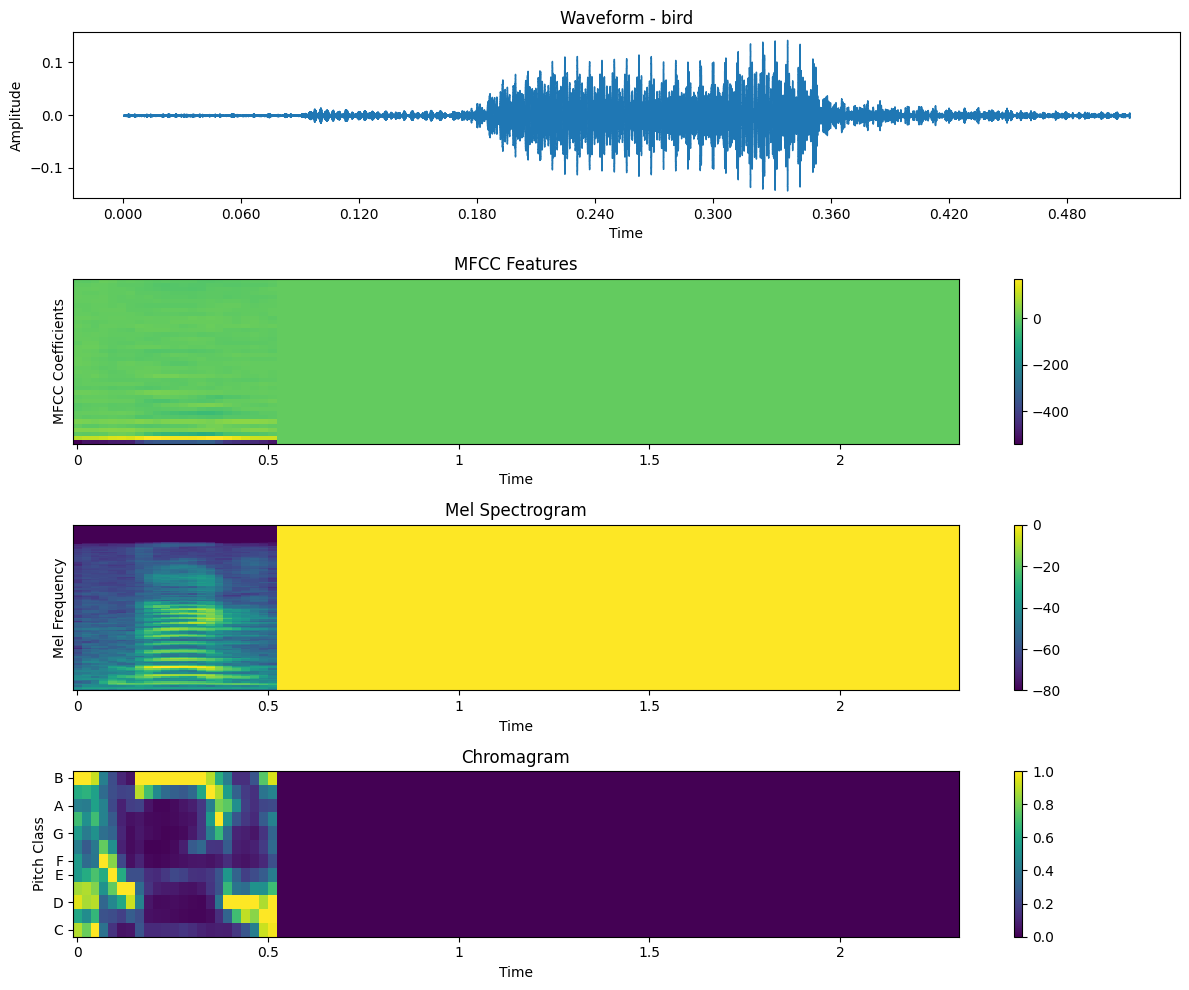

In [7]:
# Visualize features for a sample audio file
sample_file = df['file_path'].iloc[0]
sample_label = df['label'].iloc[0]

print(f"Visualizing features for: {sample_label}")

# Load audio
audio, sr = librosa.load(sample_file, sr=22050)

# Extract features
mfcc = extract_mfcc(sample_file)
mel_spec = extract_mel_spectrogram(sample_file)
chroma = extract_chromagram(sample_file)

# Create visualizations
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Waveform
librosa.display.waveshow(audio, sr=sr, ax=axes[0])
axes[0].set_title(f'Waveform - {sample_label}')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')

# MFCC
img1 = librosa.display.specshow(mfcc, x_axis='time', ax=axes[1], cmap='viridis')
axes[1].set_title('MFCC Features')
axes[1].set_ylabel('MFCC Coefficients')
fig.colorbar(img1, ax=axes[1])

# Mel Spectrogram
img2 = librosa.display.specshow(mel_spec, x_axis='time', ax=axes[2], cmap='viridis')
axes[2].set_title('Mel Spectrogram')
axes[2].set_ylabel('Mel Frequency')
fig.colorbar(img2, ax=axes[2])

# Chromagram
img3 = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=axes[3], cmap='viridis')
axes[3].set_title('Chromagram')
axes[3].set_ylabel('Pitch Class')
fig.colorbar(img3, ax=axes[3])

plt.tight_layout()
plt.show()

## Step 4: Prepare Data for CNN

Extract features for all files and prepare train/test sets:

In [8]:
# Extract features for all files
# Choose feature extraction method (change this to experiment)
feature_extractor = extract_mfcc  # Try: extract_mel_spectrogram or extract_chromagram

print("Extracting features from all audio files...")
features = []
valid_labels = []

for idx, row in df.iterrows():
    feature = feature_extractor(row['file_path'])
    if feature is not None:
        features.append(feature)
        valid_labels.append(row['label'])
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(df)} files")

print(f"\nTotal features extracted: {len(features)}")

# Convert to numpy arrays
X = np.array(features)
print(f"Feature shape: {X.shape}")

# Reshape for CNN (add channel dimension)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(f"Reshaped features: {X.shape}")

# Encode labels
label_map = {label: idx for idx, label in enumerate(sorted(set(valid_labels)))}
print(f"Label mapping: {label_map}")
y = np.array([label_map[label] for label in valid_labels])
y = to_categorical(y, num_classes=len(label_map))
print(f"Labels shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train labels: {y_train.shape}, Test labels: {y_test.shape}")

Extracting features from all audio files...
Processed 50/610 files
Processed 100/610 files
Processed 150/610 files
Processed 200/610 files
Processed 250/610 files
Processed 300/610 files
Processed 350/610 files
Processed 400/610 files
Processed 450/610 files
Processed 500/610 files
Processed 550/610 files
Processed 600/610 files

Total features extracted: 610
Feature shape: (610, 40, 100)
Reshaped features: (610, 40, 100, 1)
Label mapping: {'bird': 0, 'cat': 1, 'dog': 2}
Labels shape: (610, 3)

Train set: (488, 40, 100, 1), Test set: (122, 40, 100, 1)
Train labels: (488, 3), Test labels: (122, 3)


## Step 5: Define CNN Model

In [9]:
# Define CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 21, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,707 (2.23 MB)

 Trainable params: 584,707 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train and Evaluate

Training the model...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6964 - loss: 0.6878 - val_accuracy: 0.7951 - val_loss: 0.5818
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6962 - loss: 0.6467 - val_accuracy: 0.7213 - val_loss: 0.5934
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6961 - loss: 0.5988 - val_accuracy: 0.8033 - val_loss: 0.5811
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7435 - loss: 0.5590 - val_accuracy: 0.8115 - val_loss: 0.5316
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8061 - loss: 0.4821 - val_accuracy: 0.8770 - val_loss: 0.4357
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8114 - loss: 0.5048 - val_accuracy: 0.9016 - val_loss: 0.3820
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8310 - loss: 0.4500 - val_accuracy: 0.8770 - val_loss: 0.3898
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8665 - loss: 0.3594 - va

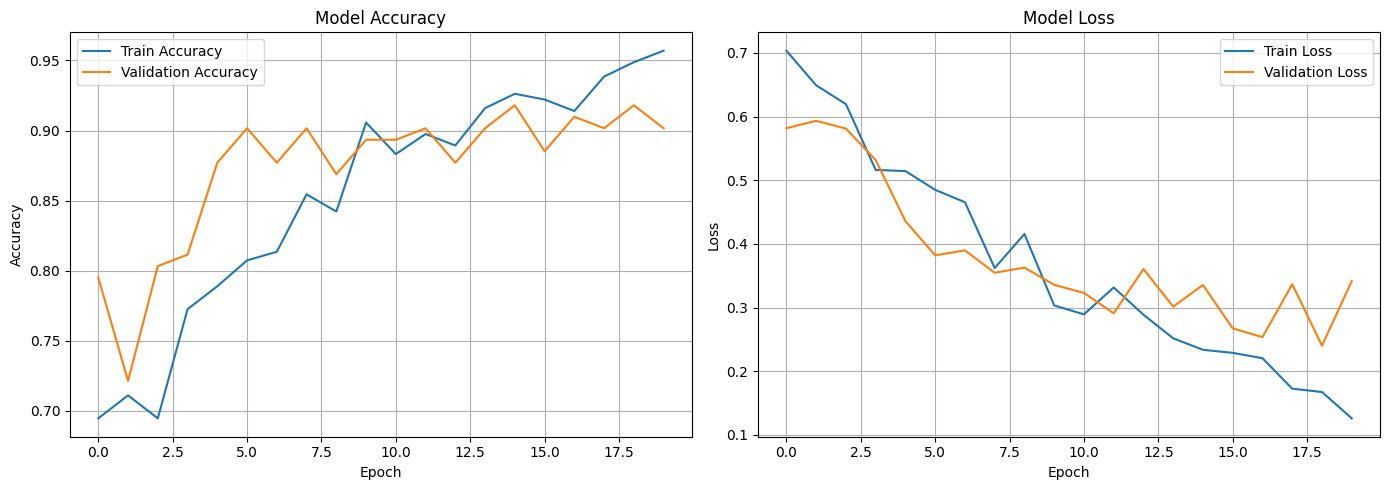


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 1: Predicted: dog, Actual: dog
Sample 2: Predicted: cat, Actual: cat
Sample 3: Predicted: bird, Actual: bird
Sample 4: Predicted: bird, Actual: cat
Sample 5: Predicted: cat, Actual: cat


In [11]:
# Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Make predictions on a few test samples
print("\nSample Predictions:")
predictions = model.predict(X_test[:5])
reverse_label_map = {v: k for k, v in label_map.items()}

for i in range(5):
    predicted_class = np.argmax(predictions[i])
    actual_class = np.argmax(y_test[i])
    print(f"Sample {i+1}: Predicted: {reverse_label_map[predicted_class]}, Actual: {reverse_label_map[actual_class]}")

## Step 7: Experimentation

- Try using Mel Spectrogram and Chromagram as features instead of MFCC by changing the `feature_extractor` function in the data preparation.
- Modify parameters like `n_mfcc`, `n_mels`, `max_len`.
- Tune CNN architecture (add layers, change filters).
- Compare results and report observations.
